#Tasks
- import dataset
- transform if necessary --> will need to transform into torch format
- create train/dev/test data loaders
- make sure data is 3x32x32
- categorize with a CNN
- plot train test/dev loss, train/dev acc, final test acc

In [23]:
import torchvision
import torchvision.transforms as transforms
# import libraries
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset,SubsetRandomSampler
from sklearn.model_selection import train_test_split

# for getting summary info on models
from torchsummary import summary

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

<ipython-input-23-96f188be5216>:16: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


In [11]:
transforms = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = torchvision.datasets.CIFAR10(root='./data',
                                        train=True,
                                        download=True,
                                        transform=transforms)
testset = torchvision.datasets.CIFAR10(root='./data',
                                        train=False,
                                        download=True,
                                        transform=transforms)


Files already downloaded and verified
Files already downloaded and verified


In [14]:
len(testset)

10000

(45000, 5000)

In [48]:
validation_split = 0.1
shuffle_dataset = True
random_seed = 42

# Create data indices for training and validation splits
dataset_size = len(trainset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))

if shuffle_dataset:
    np.random.seed(random_seed)
    np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

# Create data samplers and loaders
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = DataLoader(trainset, batch_size=64, sampler=train_sampler, drop_last=True)
validation_loader = DataLoader(trainset, batch_size=len(val_indices), sampler=valid_sampler, drop_last=True)
test_loader = DataLoader(testset, batch_size=len(testset), shuffle=False)

print(f"Number of training batches: {len(train_loader)}")
print(f"Number of validation batches: {len(validation_loader)}")
print(f"Number of test batches: {len(test_loader)}")

Number of training batches: 703
Number of validation batches: 1
Number of test batches: 1


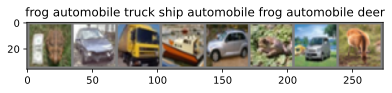

In [49]:
images, labels = next(iter(train_loader))
images_subset = images[:8]
labels_subset = labels[:8]

# Create a grid of the selected images and plot
grid_img = torchvision.utils.make_grid(images_subset, nrow=8)
plt.imshow(grid_img.permute(1, 2, 0) / 2 + 0.5)
plt.title(' '.join(trainset.classes[label] for label in labels_subset))
plt.show()

In [40]:
print(trainset.classes)
X,y = next(iter(train_loader))
class_names = [trainset.classes[label] for label in y]
# class_names[:8]

imgSize = X.shape[2]

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [41]:
# create a class for the model
def makeTheNet():

  class emnistnet(nn.Module):
    def __init__(self):
      super().__init__()

      self.conv1  = nn.Conv2d(in_channels=3,
                              out_channels=64,
                              kernel_size=3,
                              padding=1)
      self.bnorm1 = nn.BatchNorm2d(self.conv1.out_channels)

      self.conv2  = nn.Conv2d(in_channels=self.bnorm1.num_features,
                              out_channels=128,
                              kernel_size=3,
                              padding=1)
      self.bnorm2 = nn.BatchNorm2d(self.conv2.out_channels)

      self.conv3  = nn.Conv2d(in_channels=self.bnorm2.num_features,
                                    out_channels=256,
                                    kernel_size=3,
                                    padding=1)
      self.bnorm3 = nn.BatchNorm2d(self.conv3.out_channels) # input the number of channels in this layer

      conv1postPool = int((np.floor((imgSize + (2*self.conv1.padding[0]) - self.conv1.kernel_size[0])/self.conv1.stride[0]) + 1)/2)
      conv2postPool = int((np.floor((conv1postPool + (2*self.conv2.padding[0]) - self.conv2.kernel_size[0])/self.conv2.stride[0]) + 1)/2)
      conv3postPool = int((np.floor((conv2postPool + (2*self.conv2.padding[0]) - self.conv3.kernel_size[0])/self.conv3.stride[0]) + 1)/2)

      ### -------------- linear decision layers -------------- ###
      self.fc1 = nn.Linear(conv3postPool**2 * self.bnorm3.num_features,256)
      self.fc2 = nn.Linear(256,64)
      self.fc3 = nn.Linear(64, 10)


    def forward(self,x):

      # first block
      x = F.max_pool2d(self.conv1(x),2)
      x = F.leaky_relu(self.bnorm1(x))
      x = F.dropout(x, p=0.2, training=self.training)
      # Second block
      x = F.max_pool2d(self.conv2(x),2)
      x = F.leaky_relu(self.bnorm2(x))
      x = F.dropout(x, p=0.2, training=self.training)

      # thrid block
      x = F.max_pool2d(self.conv3(x),2)
      x = F.leaky_relu(self.bnorm3(x))
      x = F.dropout(x, p=0.2, training=self.training)

      # reshape for linear layer
      nUnits = x.shape.numel()/x.shape[0]
      x = x.view(-1,int(nUnits))

      # linear layers
      x = F.leaky_relu(self.fc1(x))
      x = F.dropout(x, p=0.5, training=self.training)
      x = F.leaky_relu(self.fc2(x))
      x = F.dropout(x, p=0.5, training=self.training)
      x = self.fc3(x)
      return x

  # create the model instance
  net = emnistnet()

  # loss function
  lossfun = nn.CrossEntropyLoss()

  # optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=.001)

  return net,lossfun,optimizer

In [43]:
# test the model with one batch
net,lossfun,optimizer = makeTheNet()

X,y = next(iter(train_loader))
yHat = net(X)

# check size of output
print('\nOutput size:')
print(yHat.shape)

# # now let's compute the loss
loss = lossfun(yHat,torch.squeeze(y))
print(' ')
print('Loss:')
print(loss)


Output size:
torch.Size([64, 10])
 
Loss:
tensor(2.3589, grad_fn=<NllLossBackward0>)


In [51]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
def trainTheModel(train_loader, val_loader):
  numepochs = 15

  net, lossfun, optimizer = makeTheNet()

  # net.to(device)

  # initialize losses
  trainLoss = torch.zeros(numepochs)
  valLoss  = torch.zeros(numepochs)
  trainAcc  = torch.zeros(numepochs)
  valAcc   = torch.zeros(numepochs)


  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    net.train()
    batchLoss = []
    batchAcc  = []
    for X,y in train_loader:

      # push data to GPU
      X = X.to(device)
      y = y.to(device)

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss and Accuracy from this batch
      batchLoss.append(loss.item())
      batchAcc.append( torch.mean((torch.argmax(yHat,axis=1) == y).float()).item() )
    # end of batch loop...

    # and get average losses and Accuracy rates across the batches
    trainLoss[epochi] = np.mean(batchLoss)
    trainAcc[epochi]  = 100*np.mean(batchAcc)

    # test performance
    X,y = next(iter(test_loader)) # extract X,y from test dataloader

    # push data to GPU
    X = X.to(device)
    y = y.to(device)

    net.eval()
    with torch.no_grad(): # deactivates autograd
      yHat = net(X)
      loss = lossfun(yHat,y)

    # get loss and Accor rate from the test batch
    valLoss[epochi] = loss.item()
    valAcc[epochi]  = 100*torch.mean((torch.argmax(yHat,axis=1) == y).float()).item()

  # end epochs

  # function output
  return trainLoss,valLoss,trainAcc,valAcc,net


In [52]:
trainLoss,valLoss,trainAcc,valAcc,net = trainTheModel(train_loader, validation_loader)

KeyboardInterrupt: 

In [ ]:
net.eval()
X,y = next(iter(test_loader))
with torch.no_grad():
  yHat = net(X)
  loss = lossfun(yHat,y)
testLoss = loss.item()
testAcc = 100*torch.mean((torch.argmax(yHat,axis=1) == y).float()).item()



In [ ]:
fig,ax = plt.subplots(2,1,figsize=(5,6))

testepoch = len(trainAcc)

ax[0].plot(trainLoss,'s-',label='Train')
ax[0].plot(valLoss,'o-',label='Test')
ax[0].scatter(testepoch, testLoss, color='red',marker='*', label='Test Accuracy', s=50)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss (CEL)')
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,'s-',label='Train')
ax[1].plot(valAcc,'o-',label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Error rates (%)')
ax[1].set_title(f'Final model val/test accuracy rate: {valAcc[-1]:.2f}/{testAcc:.2f}%')
ax[1].scatter(testepoch, testAcc, color='red',marker='*', label='Test Accuracy', s=50)
ax[1].legend()

plt.tight_layout()
plt.show()